In [4]:
# %% 
# Import core libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuration
DATASET_PATH = "/kaggle/input/natural-images/natural_images"
CLASS_NAMES = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [5]:
# %%
# Define transformations
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ViT-specific transforms
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(DATASET_PATH, transform=base_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 4829 | Val: 1034 | Test: 1036


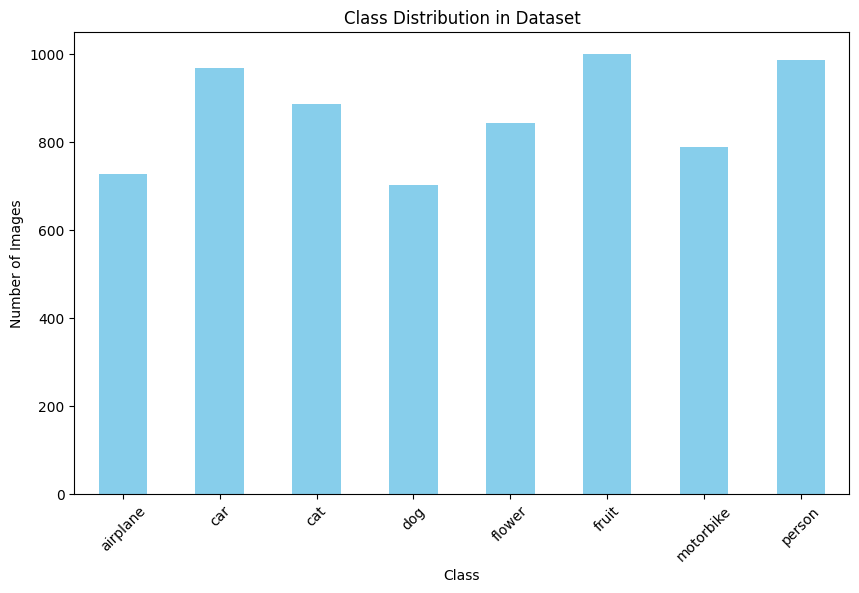

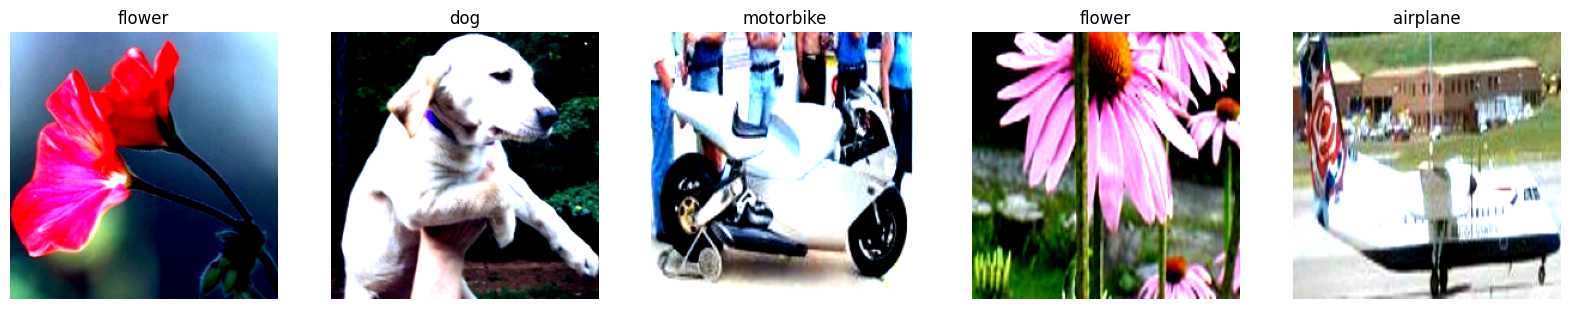

In [6]:
# %%
# Visualize class distribution
class_counts = pd.Series([len(os.listdir(os.path.join(DATASET_PATH, c))) for c in CLASS_NAMES], 
                       index=CLASS_NAMES)
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Sample images visualization
def show_sample_images(dataset, n=5):
    indices = np.random.choice(len(dataset), n)
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
        axes[i].set_title(CLASS_NAMES[label])
        axes[i].axis('off')
    plt.show()

show_sample_images(train_dataset)

In [7]:
# %%
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {'train_loss': [], 'val_acc': [], 'time': []}
    model.to(DEVICE)
    
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(running_loss/len(train_loader))
        history['val_acc'].append(100 * correct/total)
        history['time'].append(epoch_time)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {history['train_loss'][-1]:.4f} | "
              f"Val Acc: {history['val_acc'][-1]:.2f}% | Time: {epoch_time:.2f}s")
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time//60:.0f}m {total_time%60:.0f}s")
    return history, total_time

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            start_time = time.time()
            outputs = model(inputs)
            inference_times.append(time.time() - start_time)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    avg_inference_time = np.mean(inference_times)/BATCH_SIZE  # Per image time
    accuracy = accuracy_score(all_labels, all_preds) * 100
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
    
    return accuracy, avg_inference_time

In [10]:
# %%
# Model configuration
models_config = {
    'ResNet50': {
        'model': models.resnet50(weights='IMAGENET1K_V2'),
        'params': {
            'optimizer': optim.Adam,
            'lr': 1e-3,
            'epochs': 5
        }
    },
    'EfficientNet-B0': {
        'model': models.efficientnet_b0(weights='IMAGENET1K_V1'),
        'params': {
            'optimizer': optim.Adam,
            'lr': 1e-3,
            'epochs': 5
        }
    },
    'VGG16': {
        'model': models.vgg16(weights='IMAGENET1K_V1'),
        'params': {
            'optimizer': optim.SGD,
            'lr': 0.01,
            'epochs': 5
        }
    },
    'ViT-B16': {
        'model': models.vit_b_16(weights='IMAGENET1K_V1'),
        'params': {
            'optimizer': optim.AdamW,
            'lr': 5e-5,
            'epochs': 5
        }
    }
}

# Modify final layers
for model_name in models_config:
    model = models_config[model_name]['model']
    if 'resnet' in model_name.lower():
        model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    elif 'efficientnet' in model_name.lower():
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(CLASS_NAMES))
    elif 'vgg' in model_name.lower():
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(CLASS_NAMES))
    elif 'vit' in model_name.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, len(CLASS_NAMES))


Training ResNet50
Epoch 1/5 | Loss: 0.2176 | Val Acc: 95.55% | Time: 43.98s
Epoch 2/5 | Loss: 0.1053 | Val Acc: 94.39% | Time: 43.96s
Epoch 3/5 | Loss: 0.0618 | Val Acc: 96.62% | Time: 43.60s
Epoch 4/5 | Loss: 0.0540 | Val Acc: 91.10% | Time: 43.91s
Epoch 5/5 | Loss: 0.0580 | Val Acc: 97.97% | Time: 47.35s

Training completed in 3m 43s


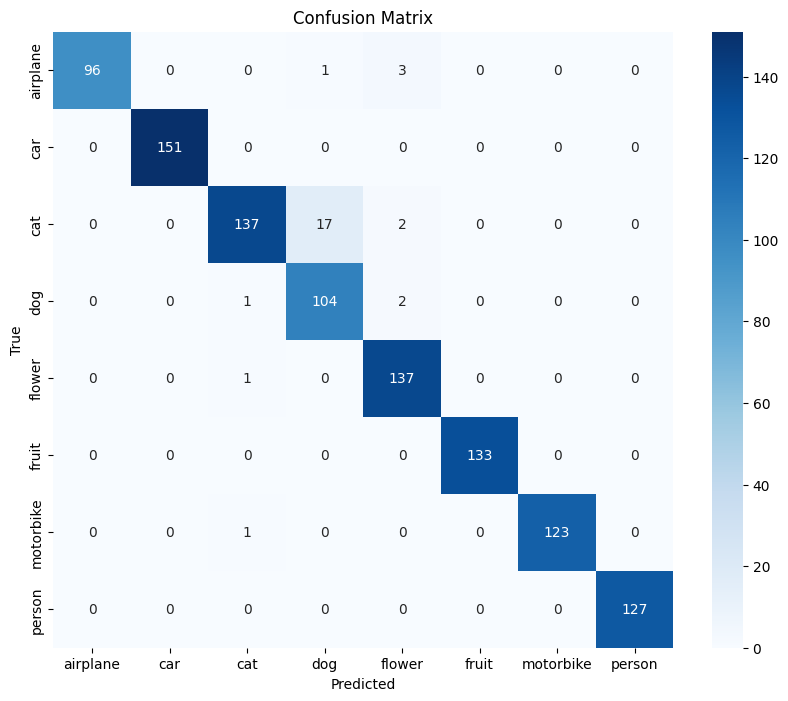


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.96      0.98       100
         car       1.00      1.00      1.00       151
         cat       0.98      0.88      0.93       156
         dog       0.85      0.97      0.91       107
      flower       0.95      0.99      0.97       138
       fruit       1.00      1.00      1.00       133
   motorbike       1.00      0.99      1.00       124
      person       1.00      1.00      1.00       127

    accuracy                           0.97      1036
   macro avg       0.97      0.97      0.97      1036
weighted avg       0.98      0.97      0.97      1036


Training EfficientNet-B0
Epoch 1/5 | Loss: 0.1544 | Val Acc: 98.94% | Time: 33.95s
Epoch 2/5 | Loss: 0.0578 | Val Acc: 98.84% | Time: 33.99s
Epoch 3/5 | Loss: 0.0556 | Val Acc: 98.74% | Time: 33.83s
Epoch 4/5 | Loss: 0.0330 | Val Acc: 99.03% | Time: 33.53s
Epoch 5/5 | Loss: 0.0185 | Val Acc: 98.94% | Time: 33.84s

Training

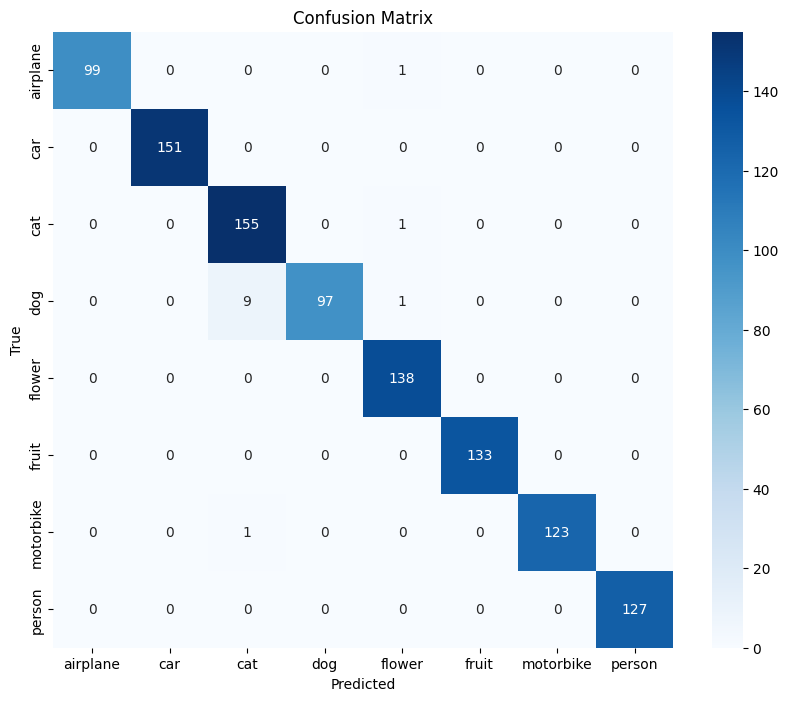


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.99      0.99       100
         car       1.00      1.00      1.00       151
         cat       0.94      0.99      0.97       156
         dog       1.00      0.91      0.95       107
      flower       0.98      1.00      0.99       138
       fruit       1.00      1.00      1.00       133
   motorbike       1.00      0.99      1.00       124
      person       1.00      1.00      1.00       127

    accuracy                           0.99      1036
   macro avg       0.99      0.99      0.99      1036
weighted avg       0.99      0.99      0.99      1036


Training VGG16
Epoch 1/5 | Loss: 0.0817 | Val Acc: 99.71% | Time: 54.36s
Epoch 2/5 | Loss: 0.0064 | Val Acc: 99.52% | Time: 54.40s
Epoch 3/5 | Loss: 0.0024 | Val Acc: 99.90% | Time: 54.38s
Epoch 4/5 | Loss: 0.0013 | Val Acc: 100.00% | Time: 54.53s
Epoch 5/5 | Loss: 0.0003 | Val Acc: 100.00% | Time: 54.27s

Training complet

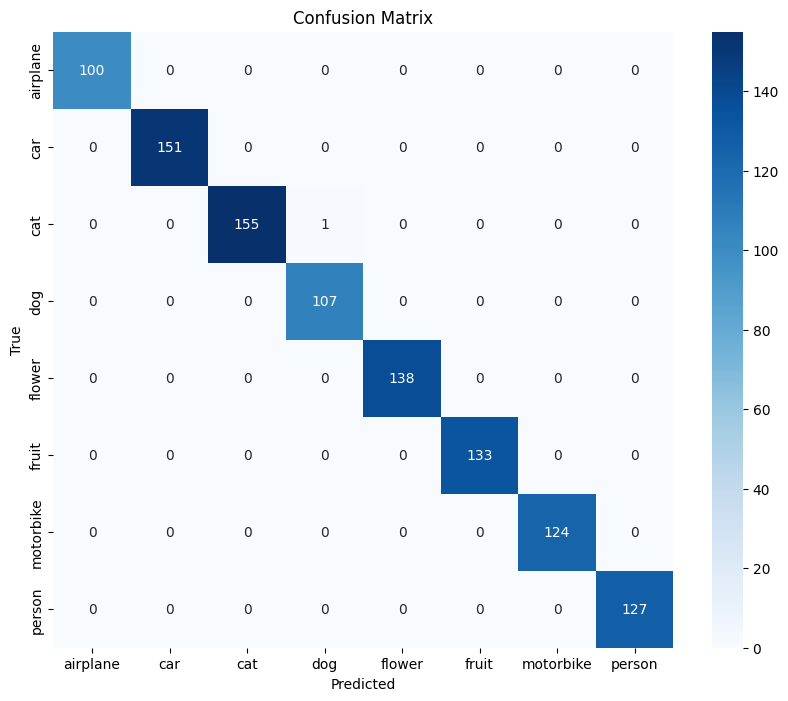


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       100
         car       1.00      1.00      1.00       151
         cat       1.00      0.99      1.00       156
         dog       0.99      1.00      1.00       107
      flower       1.00      1.00      1.00       138
       fruit       1.00      1.00      1.00       133
   motorbike       1.00      1.00      1.00       124
      person       1.00      1.00      1.00       127

    accuracy                           1.00      1036
   macro avg       1.00      1.00      1.00      1036
weighted avg       1.00      1.00      1.00      1036


Training ViT-B16
Epoch 1/5 | Loss: 0.0960 | Val Acc: 99.32% | Time: 115.85s
Epoch 2/5 | Loss: 0.0140 | Val Acc: 99.61% | Time: 115.77s
Epoch 3/5 | Loss: 0.0037 | Val Acc: 100.00% | Time: 115.77s
Epoch 4/5 | Loss: 0.0123 | Val Acc: 99.13% | Time: 115.41s
Epoch 5/5 | Loss: 0.0223 | Val Acc: 99.90% | Time: 115.77s

Training c

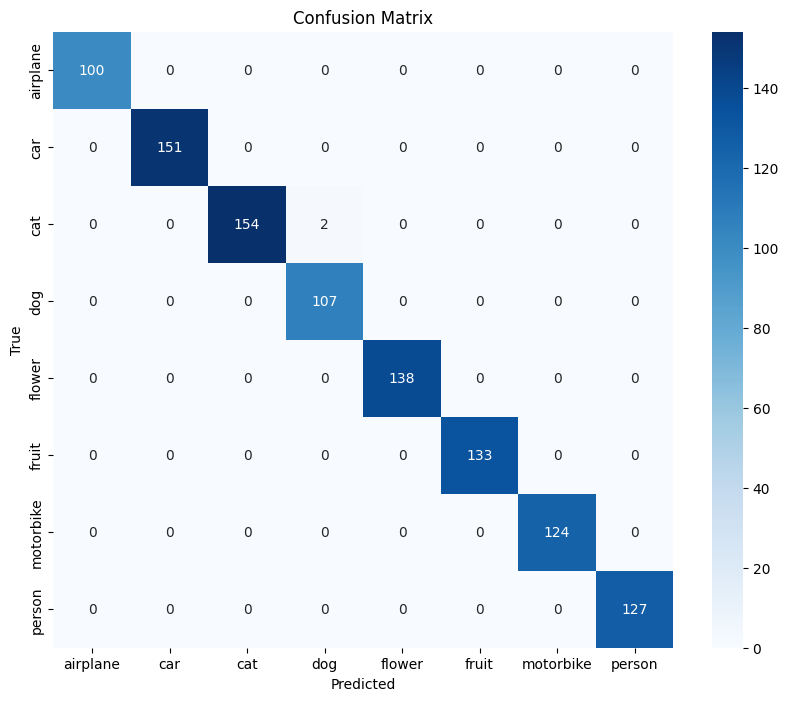


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       100
         car       1.00      1.00      1.00       151
         cat       1.00      0.99      0.99       156
         dog       0.98      1.00      0.99       107
      flower       1.00      1.00      1.00       138
       fruit       1.00      1.00      1.00       133
   motorbike       1.00      1.00      1.00       124
      person       1.00      1.00      1.00       127

    accuracy                           1.00      1036
   macro avg       1.00      1.00      1.00      1036
weighted avg       1.00      1.00      1.00      1036



In [11]:
# %%
results = []

for model_name in models_config:
    print(f"\n{'='*40}\nTraining {model_name}\n{'='*40}")
    
    # Model setup
    model = models_config[model_name]['model']
    params = models_config[model_name]['params']
    criterion = nn.CrossEntropyLoss()
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])
    
    # Training
    history, total_time = train_model(
        model, train_loader, val_loader, 
        optimizer, criterion, params['epochs']
    )
    
    # Evaluation
    test_acc, inference_time = evaluate_model(model, test_loader)
    
    # Model size
    model_size = sum(p.numel() for p in model.parameters()) / 1e6  # in millions
    
    # Store results
    results.append({
        'Model': model_name,
        'Test Accuracy (%)': test_acc,
        'Training Time (min)': total_time / 60,
        'Inference Time (ms)': inference_time * 1000,
        'Model Size (M)': model_size,
        'Training History': history
    })


Model Comparison Summary:


,Model,Test Accuracy (%),Training Time (min),Inference Time (ms),Model Size (M)
0,ResNet50,97.297297,3.713404,0.227078,23.524424
1,EfficientNet-B0,98.745174,2.819040,0.302858,4.017796
2,VGG16,99.903475,4.532198,0.061604,134.293320
3,ViT-B16,99.806950,9.642675,0.179065,85.804808


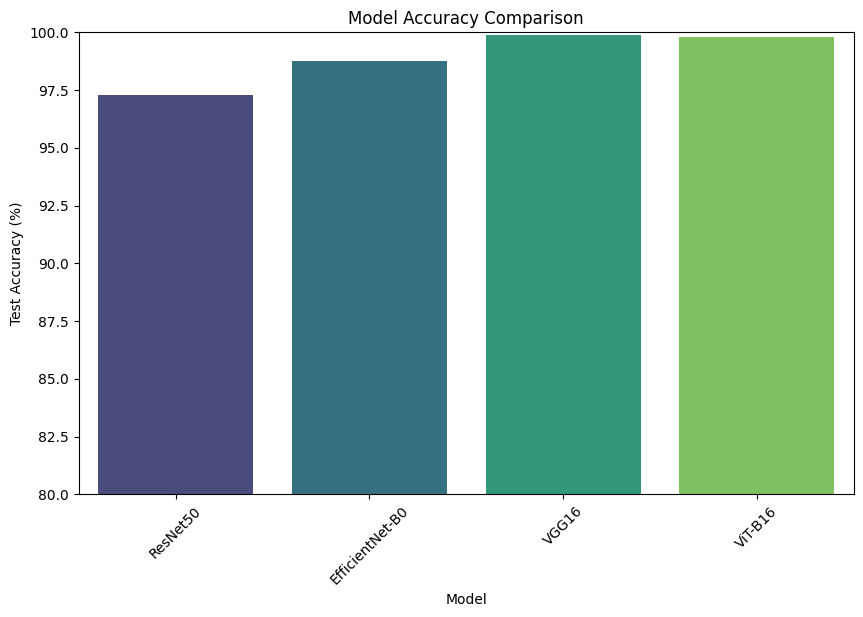

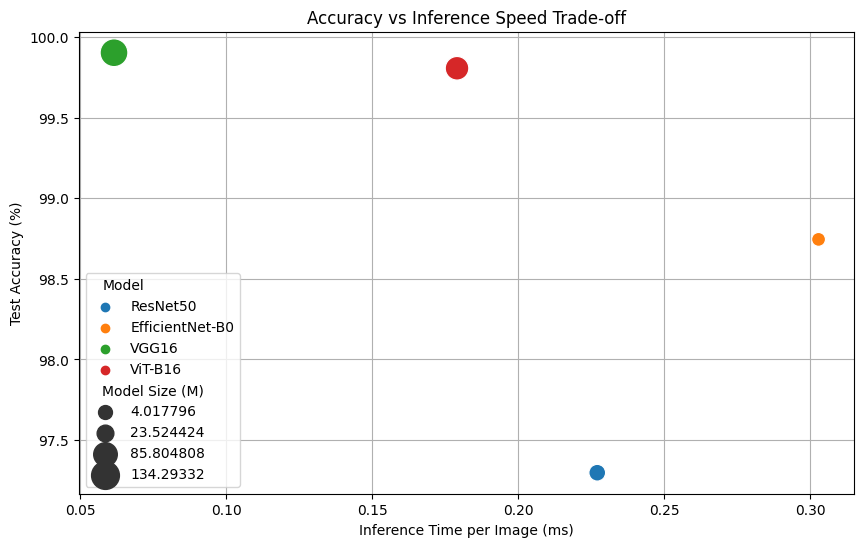

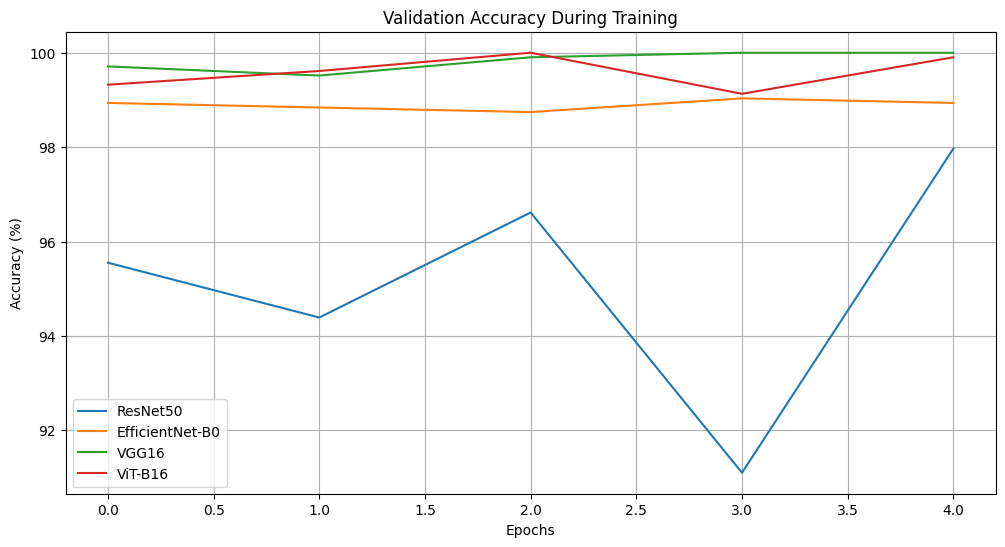

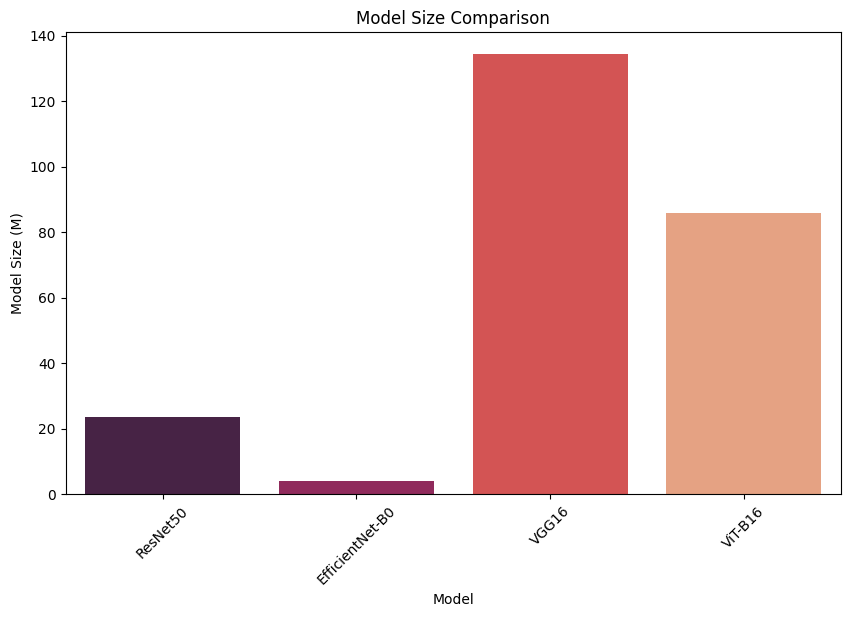

In [12]:
# %%
# Convert results to DataFrame
results_df = pd.DataFrame(results).drop('Training History', axis=1)
print("\nModel Comparison Summary:")
display(results_df.style.background_gradient(cmap='Blues', subset=['Test Accuracy (%)']))

# Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test Accuracy (%)', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(80, 100)
plt.xticks(rotation=45)
plt.show()

# Speed vs Accuracy
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Inference Time (ms)', y='Test Accuracy (%)', 
                size='Model Size (M)', sizes=(100, 400),
                hue='Model', data=results_df, palette='tab10')
plt.title('Accuracy vs Inference Speed Trade-off')
plt.xlabel('Inference Time per Image (ms)')
plt.grid(True)
plt.show()

# Training Dynamics Comparison
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res['Training History']['val_acc'], label=res['Model'])
plt.title('Validation Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Model Size Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Model Size (M)', data=results_df, palette='rocket')
plt.title('Model Size Comparison')
plt.xticks(rotation=45)
plt.show()